In [32]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import lightning as L
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [33]:
# directory paths
train_dir = "./data/train/"
test_dir = "./data/test/"

# load data to dataframe with file names and labels
def load_to_df(file_path):
	file_names = []
	labels = []
	folders = os.listdir(file_path)
	for folder in folders:
		folder_path = file_path + folder
		files = os.listdir(file_path + folder)
		for file in files:
			file_names.append(file)
			labels.append(folder)

	df = pd.DataFrame({"file_name": file_names, "label": labels})
	return df

# load data to dataframes
train_df = load_to_df(train_dir)
test_df = load_to_df(test_dir)

# Dataset creation

In [34]:
# setup for the dataset
class BrainTumorDataset(Dataset):
	def __init__(self, df, file_path, transform=None):
		self.df = df
		self.file_path = file_path
		self.transform = transform

	def __len__(self):
		return len(self.df)

	def __getitem__(self, idx):
		file_name = self.df.iloc[idx, 0]
		label = self.df.iloc[idx, 1]
		img = Image.open(self.file_path + label + "/" + file_name)
		
		img = img.convert("L") # convert to RGB

		if self.transform:
			img = self.transform(img)

		return img, label

# transform the images to ensure equal size and tensors
transform = transforms.Compose([
	transforms.Resize((512, 512)),
	transforms.ToTensor()
])

train_dataset = BrainTumorDataset(train_df, train_dir, transform=transform)
test_dataset = BrainTumorDataset(test_df, test_dir, transform=transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

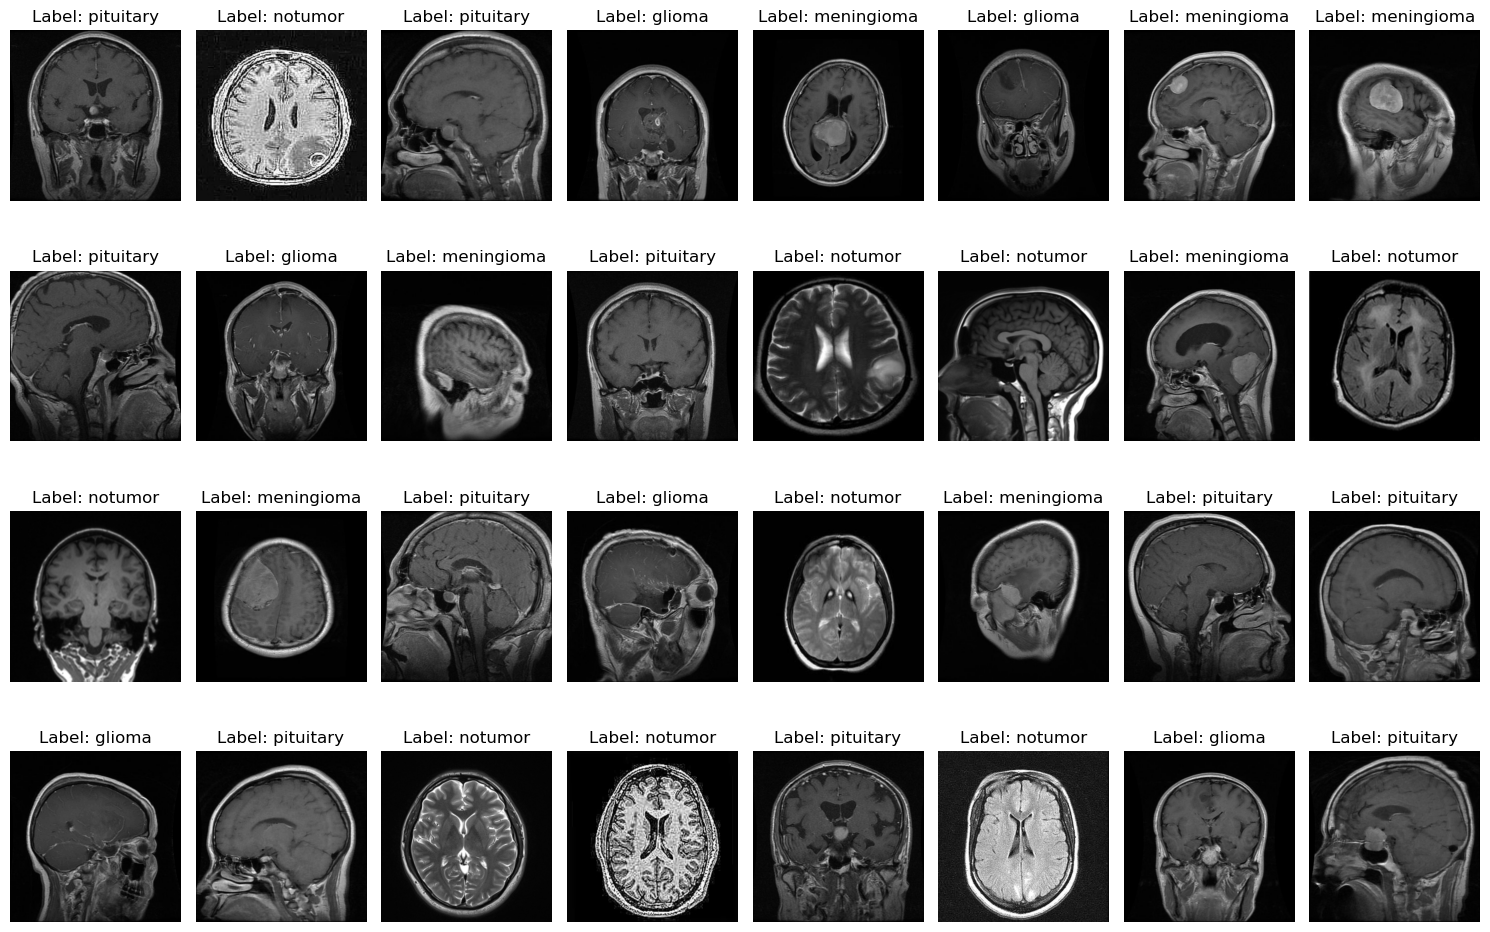

In [35]:
# Function to show a grid of images from a single batch
def show_image_grid(images, labels, rows=4, cols=8):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()
    
    # Display each image in the batch
    for i in range(len(images)):
        img = images[i].numpy().transpose((1, 2, 0))  # Convert to HWC format for plotting
        img = np.clip(img, 0, 1)  # Ensure valid display range
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis("off")  # Hide axes

    # Hide any extra subplots in case there are fewer images than grid cells
    for j in range(len(images), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Display the images in a grid from one batch in the DataLoader
for imgs, labels in train_loader:
    show_image_grid(imgs, labels)
    break  

# Setup network architecture with vision transformer

In [ ]:
class VisionTransformer(L.LightningModule):
    def __init__(self, 
                 embedding_dim=64, 
                 patch_size=32, 
                 num_layers=4, 
                 n_heads=8, 
                 dim_feedforward=64):
        super().__init__()
        self.embedding = nn.Conv2d(
            1, embedding_dim, kernel_size=patch_size, stride=patch_size
        )

        # class token for classification
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        # positional embedding
        self.positional_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))
        # transformer encoder layer
        self.encoder = nn.TransformerEncoder( # we can add a norm between each encoder layer here
            nn.TransformerEncoderLayer( 
                d_model=embedding_dim, nhead=n_heads, dim_feedforward=dim_feedforward
            ),
            num_layers=num_layers,
            enable_nested_tensor=False,
        )
        
		# linear layer for classification
        # TODO

    def forward(self, x):
        x = self.embedding(x)
        # TODO
        return x


# test with random image
model = VisionTransformer(embedding_dim=8)
imgs, labels = next(iter(train_loader))
output = model(imgs[0])
output = output.flatten(start_dim=1)
print(output.shape)

torch.Size([8, 256])
